In [ ]:
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from tqdm import tqdm, trange
import os
import math

## Import Dataset

In [ ]:
df_train = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/train_data.csv", index_col='id')
df_valid = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/validation_data.csv", index_col='id')
df_test = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/test_data.csv", index_col='id')

print (df_train.shape)
print (df_test.shape)
print (df_valid.shape)

(127655, 7)
(63972, 7)
(31914, 7)


In [ ]:
display (df_train.head(5))
display (df_valid.head(5))
display (df_test.head(5))

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
1f248a9d4e6a747e,unsigned comment by userjohn4890,0,0,0,0,0,0
4cb60854285a70b8,how can you block me when you are just an editor,0,0,0,0,0,0
4462a926cf64b036,berwickshire i have added the category berwi...,0,0,0,0,0,0
68d5bbcc7bdf32e3,struggling with format issues constant interr...,0,0,0,0,0,0
d8869e230033c100,the article team kman has been speedily delete...,0,0,0,0,0,0


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
d6d594838a3870c0,dyk suggestion olvir hnufa hi brian i en...,0,0,0,0,0,0
c7f79f4af1e0aad6,junior barranquilla wtf how did you come up w...,1,0,0,0,0,0
d4495c7b6fda20fc,and whats the point of editing a file if your ...,1,0,0,0,1,0
b56d7565b21093b6,your submission at articles for creation yo...,0,0,0,0,0,0
b8511058fc958522,your incivility knows no bounds you are a ma...,0,0,0,0,0,0


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0
000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
0003e1cccfd5a40a,it says it right there that it is a type t...,0,0,0,0,0,0
00059ace3e3e9a53,before adding a new product to the list m...,0,0,0,0,0,0


## Preprocess Data

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = df_train["comment_text"].values
valid_text_list = df_valid["comment_text"].values
test_text_list = df_test["comment_text"].values

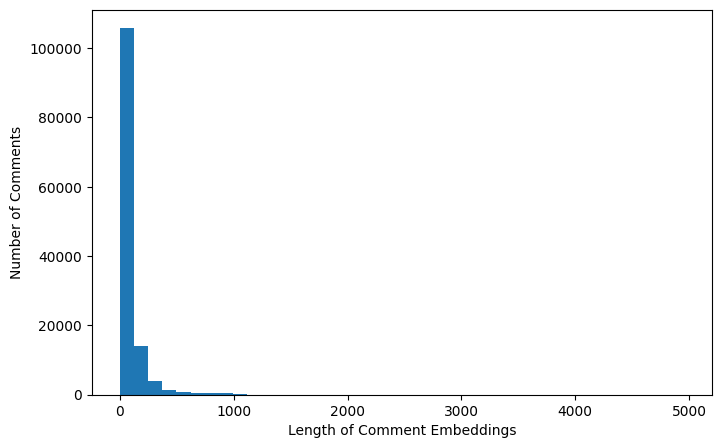

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

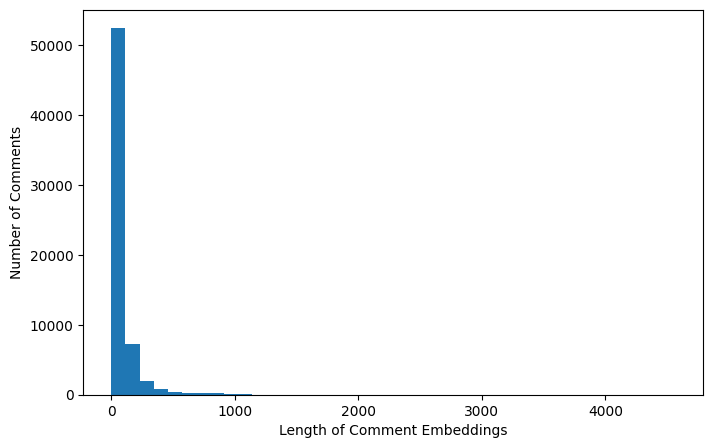

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
valid_input_ids = tokenize_inputs(valid_text_list, tokenizer, num_embeddings=250)
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
valid_attention_masks = create_attn_masks(valid_input_ids)
test_attention_masks = create_attn_masks(test_input_ids)


In [ ]:
# add input ids and attention masks to the dataframe
df_train["features"] = train_input_ids.tolist()
df_train["masks"] = train_attention_masks

df_valid["features"] = valid_input_ids.tolist()
df_valid["masks"] = valid_attention_masks

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks

In [ ]:
display (df_train.head(5))
display (df_valid.head(5))
display (df_test.head(5))

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,features,masks
id,,,,,,,,,
1f248a9d4e6a747e,unsigned comment by userjohn4890,0,0,0,0,0,0,"[422, 14121, 1709, 37, 1930, 22116, 3296, 2939...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4cb60854285a70b8,how can you block me when you are just an editor,0,0,0,0,0,0,"[160, 64, 44, 2422, 110, 90, 44, 41, 125, 48, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4462a926cf64b036,berwickshire i have added the category berwi...,0,0,0,0,0,0,"[17, 2266, 7158, 7503, 17, 150, 47, 462, 18, 3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
68d5bbcc7bdf32e3,struggling with format issues constant interr...,0,0,0,0,0,0,"[4831, 33, 2966, 705, 4649, 22006, 23, 36, 27,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
d8869e230033c100,the article team kman has been speedily delete...,0,0,0,0,0,0,"[18, 1447, 230, 17, 267, 249, 51, 72, 1781, 62...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,features,masks
id,,,,,,,,,
d6d594838a3870c0,dyk suggestion olvir hnufa hi brian i en...,0,0,0,0,0,0,"[17, 2087, 267, 9548, 17, 1529, 8746, 17, 5006...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
c7f79f4af1e0aad6,junior barranquilla wtf how did you come up w...,1,0,0,0,0,0,"[4867, 1808, 2156, 2857, 7989, 17, 694, 46, 72...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
d4495c7b6fda20fc,and whats the point of editing a file if your ...,1,0,0,0,1,0,"[21, 113, 23, 18, 424, 20, 9756, 24, 1450, 108...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
b56d7565b21093b6,your submission at articles for creation yo...,0,0,0,0,0,0,"[73, 10468, 38, 2883, 28, 2936, 73, 1447, 1046...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
b8511058fc958522,your incivility knows no bounds you are a ma...,0,0,0,0,0,0,"[73, 25, 27277, 769, 2691, 116, 4914, 23, 44, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,features,masks
id,,,,,,,,,
0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0,"[4553, 44, 28, 2172, 17, 150, 232, 172, 1790, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0,"[7949, 7290, 52, 335, 27, 11601, 4, 3, 0, 0, 0...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0,"[6708, 53, 25401, 714, 22, 1319, 3682, 343, 44...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
0003e1cccfd5a40a,it says it right there that it is a type t...,0,0,0,0,0,0,"[36, 349, 36, 203, 105, 29, 36, 27, 24, 1037, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
00059ace3e3e9a53,before adding a new product to the list m...,0,0,0,0,0,0,"[134, 1679, 24, 109, 953, 22, 18, 649, 144, 51...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


## Train, Valid Split

In [ ]:
X_train = df_train["features"].values.tolist()
X_valid = df_valid["features"].values.tolist()

train_masks = df_train["masks"].values.tolist()
valid_masks = df_valid["masks"].values.tolist()

label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
Y_train = df_train[label_cols].values.tolist()
Y_valid = df_valid[label_cols].values.tolist()

## Create Dataloaders

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

<ipython-input-17-4f6268932cd1>:10: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  train_masks = torch.tensor(train_masks, dtype=torch.long)
<ipython-input-17-4f6268932cd1>:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  valid_masks = torch.tensor(valid_masks, dtype=torch.long)


In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
      optimizer.zero_grad()
      # Forward pass
      loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
      tr_loss += loss.item()
      num_train_samples += b_labels.size(0)
      # Backward pass
      loss.backward()
      # Update parameters and take a step using the computed gradient
      optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
      with torch.no_grad():
        # Forward pass, calculate validation loss
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
        eval_loss += loss.item()
        num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

  return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

## Train Model from Scratch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
        
    if labels is not None:
      loss_fct = BCEWithLogitsLoss()
      loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_toxic.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Mounted at /content/drive


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss vs Number of Epochs')

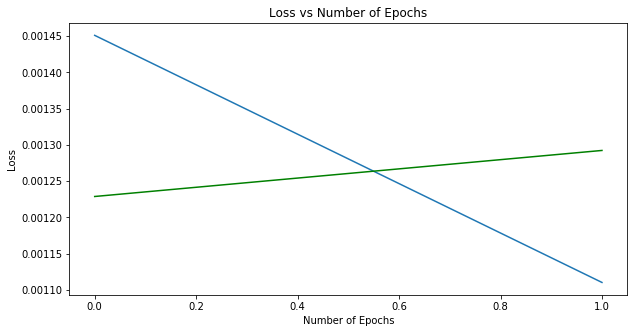

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Train Model From Previous Checkpoint

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Models/xlnet_toxic.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [ ]:
num_epochs=3
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.0011425215618740714


Epoch:  33%|███▎      | 1/3 [1:28:32<2:57:05, 5312.90s/it]

Valid loss: 0.0012287353436323532


Train loss: 0.0011403310295474713


Epoch:  67%|██████▋   | 2/3 [2:57:02<1:28:31, 5311.98s/it]

Valid loss: 0.0012287353436323532




Text(0.5, 1.0, 'Loss vs Number of Epochs')

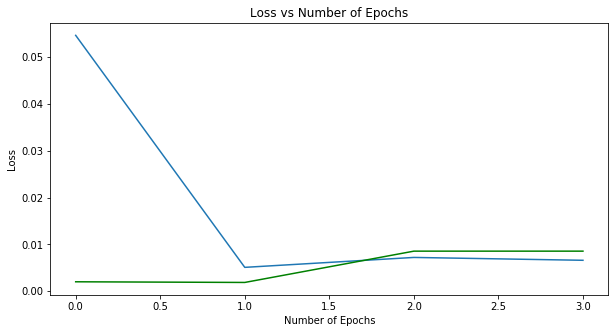

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

## Get Predictions

In [ ]:
def generate_predictions(model, df, num_labels, device="cpu", batch_size=32):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = np.array([]).reshape(0, num_labels)
  
  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
      pred_probs = np.vstack([pred_probs, logits])
  
  return pred_probs

In [ ]:
num_labels = len(label_cols)
pred_probs = generate_predictions(model, test, num_labels, device="cuda", batch_size=32)
pred_probs

In [ ]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

test["toxic"] = pred_probs[:,0]
test["severe_toxic"] = pred_probs[:,1]
test["obscene"] = pred_probs[:,2]
test["threat"] = pred_probs[:,3]
test["insult"] = pred_probs[:,4]
test["identity_hate"] = pred_probs[:,5]

In [ ]:
test.head()

,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,,,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.973646e-01,6.810126e-01,9.943510e-01,2.811275e-01,9.655939e-01,6.173821e-01
0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.463730e-06,1.105590e-06,2.950960e-07,2.665337e-07,1.079900e-07,1.663244e-07
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.510164e-06,3.645308e-07,3.329686e-07,3.394477e-07,1.168160e-07,1.529464e-07
00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.565799e-08,7.156541e-08,4.725178e-09,3.286844e-08,2.539988e-08,2.742011e-08
00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.958533e-06,1.661719e-07,1.494095e-07,2.325547e-07,1.739687e-07,1.017955e-07


In [ ]:
test_to_csv = test.reset_index()
test_to_csv.head()

,id,comment_text,features,masks,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,"[17, 4333, 15683, 17, 1653, 1614, 27, 70, 2718...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.973646e-01,6.810126e-01,9.943510e-01,2.811275e-01,9.655939e-01,6.173821e-01
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"[5847, 5383, 40, 17, 213, 722, 369, 5847, 5383...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",3.463730e-06,1.105590e-06,2.950960e-07,2.665337e-07,1.079900e-07,1.663244e-07
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...","[17, 12, 5847, 5383, 1675, 5847, 5383, 6940, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.510164e-06,3.645308e-07,3.329686e-07,3.394477e-07,1.168160e-07,1.529464e-07
3,00017563c3f7919a,":If you have a look back at the source, the in...","[17, 60, 1963, 44, 47, 24, 338, 126, 38, 18, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.565799e-08,7.156541e-08,4.725178e-09,3.286844e-08,2.539988e-08,2.742011e-08
4,00017695ad8997eb,I don't anonymously edit articles at all.,"[17, 150, 220, 26, 46, 9502, 111, 8619, 2883, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.958533e-06,1.661719e-07,1.494095e-07,2.325547e-07,1.739687e-07,1.017955e-07


In [ ]:
cwd = os.getcwd()
pred_save_path = output_model_file = os.path.join(cwd, "drive/My Drive/Data/toxic_1_epoch.csv")
test_to_csv[["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].to_csv(pred_save_path, index=False)

In [ ]:
np.round(pred_probs)